In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

### Settings

This should be the config file you use

In [2]:
# cancerTypeDetailed or cancerType or oncotreeLevel2
analysis_type = 'cancerType'

In [3]:
config = "../global_config_bash_4.rc"

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# Merged FACETS cbioportal file
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

In [6]:
use_facets = False
# Merged FACETS results
if use_facets :
    facets = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.FACETS_gene_results.tsv', sep = '\t')

### Set up oncotree codes

In [7]:
import requests

url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {
    'Accept': 'application/json'
}

response = requests.get(url, headers=headers)

def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

In [8]:
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


### Clean Up Dataframe

In [9]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

In [10]:
manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered','osStatus', 'osMonths', 'deIDAge', 'stageHighest', 'sampleType', 'tumorBurdenScore']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')
echo['oncotreeLevel2'] = ""
for i, row in echo.iterrows() :
    for key in oncotree_dict :
        if row['oncotreeCode'] in oncotree_dict[key] :
            echo.loc[i, 'oncotreeLevel2'] = key

In [11]:
echo.columns

Index(['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene',
       'log2', 'cn', 'ecDNA_prob', 'ecDNA_status', 'sampleId', 'cancerType',
       'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType',
       'mutationCount', 'fractionAltered', 'osStatus', 'osMonths', 'deIDAge',
       'stageHighest', 'sampleType', 'tumorBurdenScore', 'oncotreeLevel2'],
      dtype='object')

Add facets results to echo

In [12]:
if use_facets :
    
    facets_cn_dict = {}
    facets_amp_dict = {}
    
    for i, row in facets.iterrows() :
        if row['gene'] != 'No_genes_above_ECHO_amplification_threshold' :
            to_hash = row['sample'] + '_' + row['gene']
            facets_cn_dict[to_hash] = float(row['tcn'])
            facets_amp_dict[to_hash] = row['cn_state']
    
    if use_facets :
        echo['facets_cn'] = np.nan
        echo['facets_amp'] = ''
        echo['facets_amp_binary'] = "No Amp"
        
        for i, row in echo.iterrows() :
            if isinstance(row['gene'], str) :
                to_hash = row['tumorSampleId'] + '_' + row['gene']
                if to_hash in facets_cn_dict :
                    echo.loc[i, 'facets_cn'] = facets_cn_dict[to_hash]
                if to_hash in facets_amp_dict :
                    echo.loc[i, 'facets_amp'] = facets_amp_dict[to_hash]
                    if isinstance(facets_amp_dict[to_hash], str) :
                        if "AMP" in facets_amp_dict[to_hash] or "GAIN" in facets_amp_dict[to_hash] :
                            echo.loc[i, 'facets_amp_binary'] = "Amp"

Get a dictionary specific to each patient

In [13]:
# This tracks all genes with ecDNA, separated by _
ecDNA_per_patient = {}
for idx, row in echo.iterrows() :
    if row['patientId'] not in ecDNA_per_patient :
        ecDNA_per_patient[row['patientId']] = ''
    if row['ecDNA_status'] == 'ecDNA' :
        if ecDNA_per_patient[row['patientId']] == '' :
            ecDNA_per_patient[row['patientId']] = row['gene']
        else :
            ecDNA_per_patient[row['patientId']] += '_' + row['gene']

Create dataframe per patient

In [14]:
patientsList = echo['patientId'].unique()

# Tracks ecDNA status and takes the data from above
ecDNA_patient = pd.DataFrame(patientsList, columns = ['patientId'])
ecDNA_patient['ecDNAStatus'] = None
ecDNA_patient['ecDNAList'] = ''

for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'ecDNAList'] = ecDNA_per_patient[row['patientId']]
    if ecDNA_per_patient[row['patientId']] == '' :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = False
    else :
        ecDNA_patient.loc[idx, 'ecDNAStatus'] = True


Add copy number (taking the largest copy number)

In [15]:
# Not necessary right now. If you want to use max copy number as a covariate
max_copy_number = {}
for idx, row in echo.iterrows() :
    if row['patientId'] in max_copy_number :
        max_copy_number[row['patientId']] = max(max_copy_number[row['patientId']], row['cn'])
    else :
        max_copy_number[row['patientId']] = row['cn']

ecDNA_patient['max_cn'] = np.nan
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient.loc[idx, 'max_cn'] = max_copy_number[row['patientId']]


### Basic Plots

Comparing copy numbers

In [16]:
if use_facets :

    plt.figure(figsize=(8, 6))
    plt.scatter(echo['cn'], echo['facets_cn'], alpha = 0.4)
    plt.yscale('log')
    plt.xscale('log')
    plt.title("FACETS vs ECHO Copy Number")
    x_values = np.arange(max(echo['cn'].min(), echo['facets_cn'].min()), max(echo['cn'].max(), echo['facets_cn'].max()))
    
    plt.plot(x_values, x_values, color = 'red', linestyle = '--', label = 'y=x', alpha = 0.5)
    plt.xlabel('ECHO cn')
    plt.ylabel('FACETS cn')

ECHO copy number vs ecDNA call

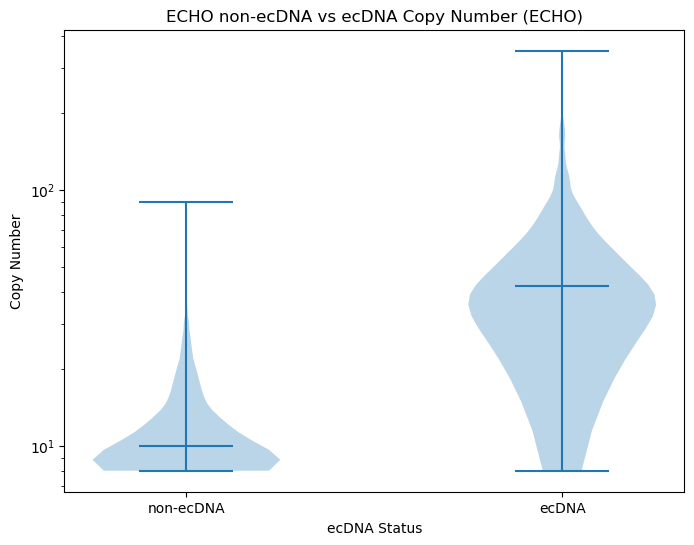

In [17]:
# Plotting violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[echo[echo['ecDNA_status'] == 'non-ecDNA']['cn'], 
                        echo[echo['ecDNA_status'] == 'ecDNA']['cn']],
               showmeans=False, showmedians=True)
plt.title('ECHO non-ecDNA vs ecDNA Copy Number (ECHO)')
plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
plt.ylabel('Copy Number')
plt.xlabel("ecDNA Status")
plt.yscale('log')
plt.show()

FACETS copy number version

In [18]:
if use_facets :
    # Plotting violin plot
    plt.figure(figsize=(8, 6))
    plt.violinplot(dataset=[echo.loc[(echo['ecDNA_status'] != 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn'], 
                            echo.loc[(echo['ecDNA_status'] == 'ecDNA') & (~echo['facets_cn'].isna()), 'facets_cn']],
                   showmeans=False, showmedians=True)
    plt.title('ECHO non-ecDNA vs ecDNA Copy Number (FACETS)')
    plt.xticks([1, 2], ['non-ecDNA', 'ecDNA']) 
    plt.ylabel('Copy Number')
    plt.xlabel("ecDNA Status")
    plt.yscale('log')
    plt.show()

corr (pearson): 0.7028092079296971
corr (log cn, pearson): 0.8043744422506205


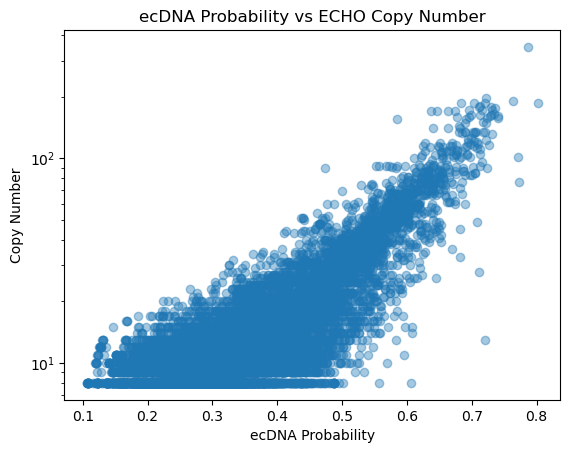

In [19]:
# plt.figure(figsize=(8, 6))
plt.scatter(echo['ecDNA_prob'], echo['cn'], alpha=0.4)
plt.ylabel("Copy Number")
plt.xlabel("ecDNA Probability")
plt.yscale('log')
plt.title("ecDNA Probability vs ECHO Copy Number")

corr_matrix = echo[['ecDNA_prob', 'cn']].corr(method='pearson')
pearson_corr = corr_matrix.loc['ecDNA_prob', 'cn']
print(f"corr (pearson): {pearson_corr}")
echo['cn_log'] = echo['cn']
import math
for i, row in echo.iterrows() :
    echo.loc[i, 'cn_log'] = math.log10(row['cn'])
corr_matrix = echo[['ecDNA_prob', 'cn_log']].corr(method='pearson')
pearson_corr_log = corr_matrix.loc['ecDNA_prob', 'cn_log']
print(f"corr (log cn, pearson): {pearson_corr_log}")


In [20]:
if use_facets :
    plt.figure(figsize=(8, 6))
    plt.scatter(echo['ecDNA_prob'], echo['facets_cn'], alpha=0.4)
    plt.ylabel("Copy Number")
    plt.xlabel("ecDNA Probability")
    plt.yscale('log')
    plt.title("ecDNA Probability vs FACETS Copy Number")

### Landscape Plots

In [21]:
import math

# Add in info from cbioportal
ecDNA_patient['vitalStatus'] = 'NA'
ecDNA_patient['cancerType'] = 'NA'
ecDNA_patient['cancerTypeDetailed'] = 'NA'
ecDNA_patient['oncotreeLevel2'] = 'NA'
ecDNA_patient['osMonths'] = np.nan
ecDNA_patient['oncogeneAmp'] = "No Amp"
if use_facets :
    ecDNA_patient['facetsAmp'] = "No Amp"
ecDNA_patient['deIDAge'] = 'NA'

# Matches patientIds to indexes
ecDNA_patient_indexes = {}
for idx, row in ecDNA_patient.iterrows() :
    ecDNA_patient_indexes[row['patientId']] = idx

# Now the info is right from echo results!
for idx, row in echo.iterrows() :
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'vitalStatus'] = row['osStatus']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerType'] = row['cancerType']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'cancerTypeDetailed'] = row['cancerTypeDetailed']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'osMonths'] = row['osMonths']
    if use_facets :

        ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'facetsAmp'] = row['facets_amp_binary']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'deIDAge'] = row['deIDAge']
    ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'oncotreeLevel2'] = row['oncotreeLevel2']

    if not math.isnan(row['ecDNA_prob']) :
        ecDNA_patient.loc[ecDNA_patient_indexes[row['patientId']], 'oncogeneAmp'] = "Amp"

ecDNA_patient['ecDNAStatusStr'] = ecDNA_patient['ecDNAStatus'].replace({True: 'ecDNA', False: 'non-ecDNA'})
ecDNA_patient['combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['oncogeneAmp']
if use_facets :
    ecDNA_patient['facets_combined_status'] = ecDNA_patient['ecDNAStatusStr'] + " & " + ecDNA_patient['facetsAmp']


In [22]:
if use_facets :
    ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type, 'oncogeneAmp', 'facetsAmp']].astype(str)
else :
    ecDNA_patient_binary = ecDNA_patient[['vitalStatus', 'ecDNAStatus', analysis_type, 'oncogeneAmp']].astype(str)

ecDNA_patient_binary_filtered = ecDNA_patient_binary.dropna(subset=[analysis_type])
ecDNA_patient_binary_filtered = ecDNA_patient_binary[ecDNA_patient_binary[analysis_type] != 'nan']

crosstab = pd.crosstab(ecDNA_patient_binary_filtered['oncogeneAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
print("Using ECHO Amplification")
crosstab

Using ECHO Amplification


ecDNAStatus,False,True
oncogeneAmp,,
Amp,363,479
No Amp,40,0


In [23]:
if use_facets :
    crosstab = pd.crosstab(ecDNA_patient_binary_filtered['facetsAmp'], ecDNA_patient_binary_filtered['ecDNAStatus'])
    print("Using FACETS Amplification")
    crosstab

In [24]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Change the labels from true/false to ecDNA status
ecDNA_patient_binary_filtered['ecDNAStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'].replace({'True': 'ecDNA', 'False': 'non-ecDNA'})
ecDNA_patient_binary_filtered['Status'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['oncogeneAmp']

if use_facets :
    ecDNA_patient_binary_filtered['facetsStatus'] = ecDNA_patient_binary_filtered['ecDNAStatus'] + " & " + ecDNA_patient_binary_filtered['facetsAmp']

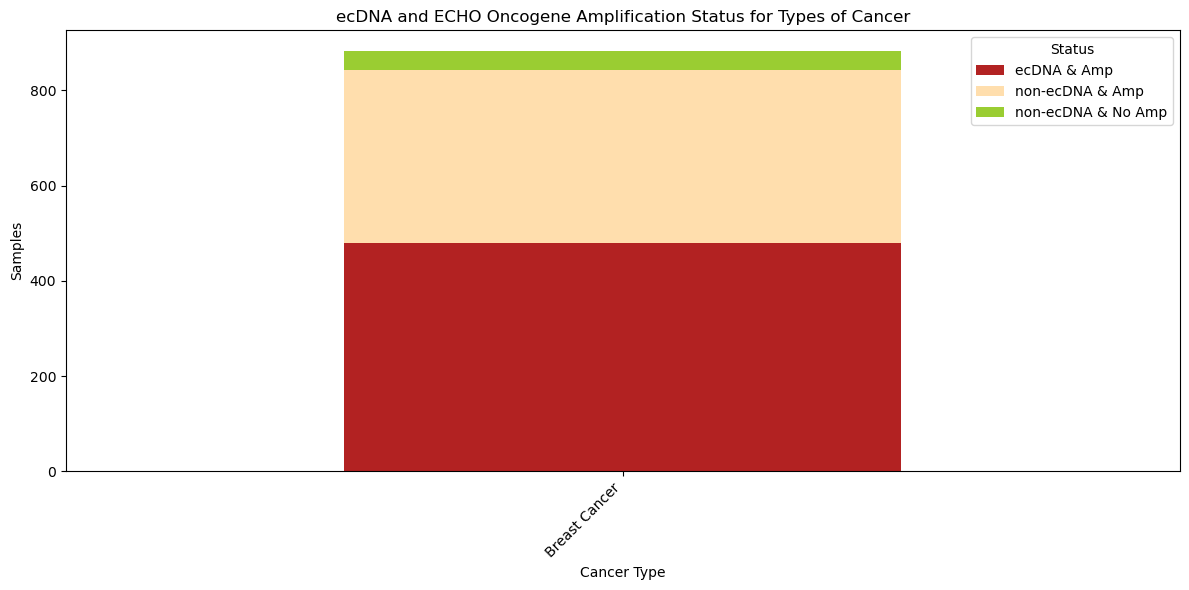

In [25]:
crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['Status'])
crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
crosstab_cancerType = crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'navajowhite', 'yellowgreen'], figsize = (12, 6))
plt.ylabel("Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amplification Status for Types of Cancer")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

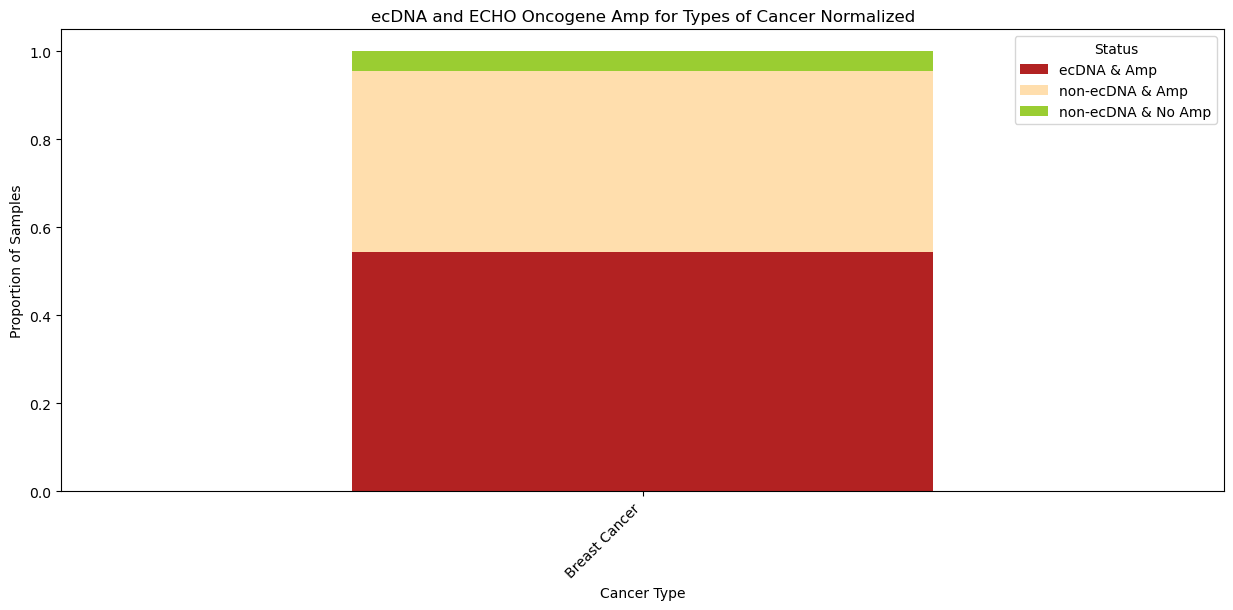

In [26]:
normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'navajowhite', 'yellowgreen'], figsize=(15,6))
plt.ylabel("Proportion of Samples")
plt.xlabel("Cancer Type")
plt.title("ecDNA and ECHO Oncogene Amp for Types of Cancer Normalized")
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
if use_facets :

    crosstab_cancerType = pd.crosstab(ecDNA_patient_binary_filtered[analysis_type], ecDNA_patient_binary_filtered['facetsStatus'])
    crosstab_cancerType = crosstab_cancerType.loc[crosstab_cancerType.sum(axis = 1) >= 10]
    crosstab_cancerType = crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
    crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'salmon', 'navajowhite', 'yellowgreen'], figsize = (15, 6))
    plt.ylabel("Samples")
    plt.xlabel("Cancer Type")
    plt.title("ecDNA and FACETS Oncogene Amplification Status for Types of Cancer")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [28]:
if use_facets :
    normalized_crosstab_cancerType = crosstab_cancerType.div(crosstab_cancerType.sum(axis = 1), axis = 0)
    normalized_crosstab_cancerType = normalized_crosstab_cancerType.sort_values(by = 'ecDNA & Amp', ascending = False)
    normalized_crosstab_cancerType.plot(kind = 'bar', stacked = True, color = ['firebrick', 'lightcoral', 'navajowhite', 'yellowgreen'], figsize=(15,6))
    plt.ylabel("Samples")
    plt.xlabel("Cancer Type")
    plt.title("ecDNA and FACETS Amp for Types of Cancer Normalized")
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [29]:
erbb2_yes = {}
erbb2_no = {}
for i, row in echo.iterrows() :
    if row['gene'] == 'ERBB2' :
        if row['ecDNA_status'] == 'ecDNA' :
            erbb2_yes[row['tumorSampleId']] = True
        else :
            erbb2_no[row['tumorSampleId']] = True
print(len(erbb2_yes))
print(len(erbb2_no))

407
493


### Survival (OS Months)

Pure ecDNA vs no ecDNA

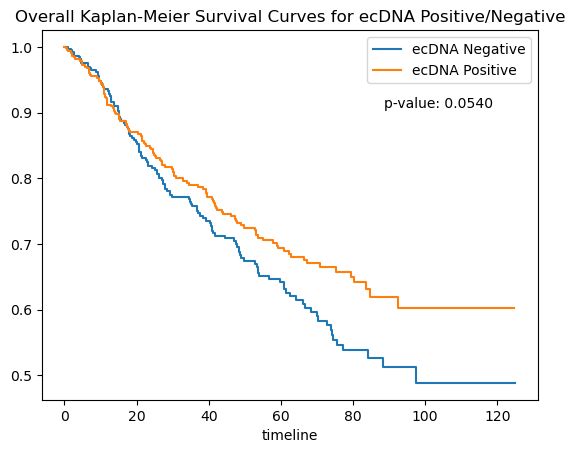

In [30]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths'])
ecDNA_patient_nona['vitalStatus_tf'] = (ecDNA_patient_nona['vitalStatus'] == 'DECEASED').astype(int)

kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['ecDNAStatus'].unique():
    subset = ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    subset['vitalStatus_tf'] = (subset['vitalStatus'] == 'DECEASED').astype(int)
    # labels
    if status == True :
        status = "ecDNA Positive"
    else :
        status = "ecDNA Negative"
    kmf.plot(show_censors=False, ci_show=False, label=f'{status}')

# get p-value
results = logrank_test(ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['osMonths'], 
                           ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['osMonths'],
                           event_observed_A=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == True]['vitalStatus_tf'], 
                           event_observed_B=ecDNA_patient_nona[ecDNA_patient_nona['ecDNAStatus'] == False]['vitalStatus_tf'])
plt.text(0.8, 0.8, f'p-value: {results.p_value:.4f}', horizontalalignment='center', 
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA Positive/Negative')

plt.legend()

Including Amplification Status (ecDNA making a call)

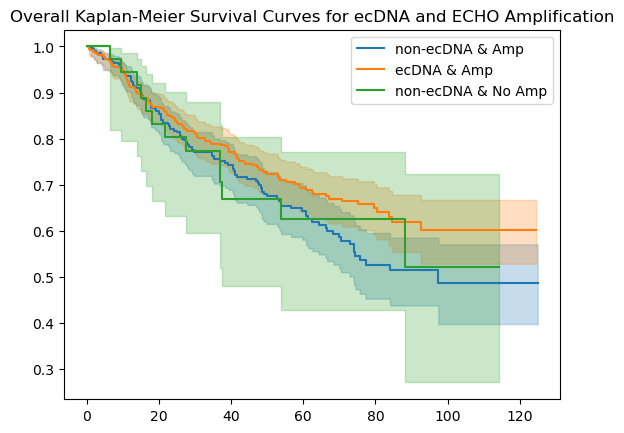

In [31]:
kmf = KaplanMeierFitter()
for status in ecDNA_patient_nona['combined_status'].unique():

    subset = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == status]
    kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Overall Kaplan-Meier Survival Curves for ecDNA and ECHO Amplification')
plt.xlabel("")
plt.legend()

In [32]:
if use_facets :
    kmf = KaplanMeierFitter()
    for status in ecDNA_patient_nona['facets_combined_status'].unique():
        subset = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    
        kmf.plot(show_censors=False, ci_show=True, label=f'{status}')
    
    # # Add labels and legend
    plt.title('Overall Kaplan-Meier Survival Curves for ecDNA and FACETS Amplification')
    plt.xlabel("")
    plt.legend()

Make a p value matrix

In [33]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = ecDNA_patient_nona['combined_status'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == group1]
    group2_data = ecDNA_patient_nona[ecDNA_patient_nona['combined_status'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['osMonths'], event_observed=(group1_data['vitalStatus'] == 'DECEASED'))
    kmf2.fit(group2_data['osMonths'], event_observed=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Perform log-rank test
    result = logrank_test(group1_data['osMonths'], group2_data['osMonths'], event_observed_A=(group1_data['vitalStatus'] == 'DECEASED'), event_observed_B=(group2_data['vitalStatus'] == 'DECEASED'))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,non-ecDNA & No Amp
non-ecDNA & Amp,0.056924,0.893458
ecDNA & Amp,,0.478934


In [34]:
if use_facets :
    from itertools import combinations
    from lifelines.statistics import logrank_test
    
    kmf = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    statuses = ecDNA_patient_nona['facets_combined_status'].unique()
    pairwise_tests = {}
    
    for group1, group2 in combinations(statuses, 2) :
        group1_data = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == group1]
        group2_data = ecDNA_patient_nona[ecDNA_patient_nona['facets_combined_status'] == group2]
    
        # Fit KM curves
        kmf.fit(group1_data['osMonths'], event_observed=(group1_data['vitalStatus'] == 'DECEASED'))
        kmf2.fit(group2_data['osMonths'], event_observed=(group2_data['vitalStatus'] == 'DECEASED'))
        
        # Perform log-rank test
        result = logrank_test(group1_data['osMonths'], group2_data['osMonths'], event_observed_A=(group1_data['vitalStatus'] == 'DECEASED'), event_observed_B=(group2_data['vitalStatus'] == 'DECEASED'))
        
        # Store p-value in dictionary
        pairwise_tests[(group1, group2)] = result.p_value
    
    p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
    for (group1, group2), p_value in pairwise_tests.items():
        if group1 != group2:
            p_values_matrix.loc[group1, group2] = p_value
    p_values_matrix = p_values_matrix.fillna("")
    
    print("P-values for KM Curves (FACETS)")
    
    styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
        'selector': 'th',
        'props': [('border', '1px solid black')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid black')]
    }])
    styled_matrix

Specific for one cancer type

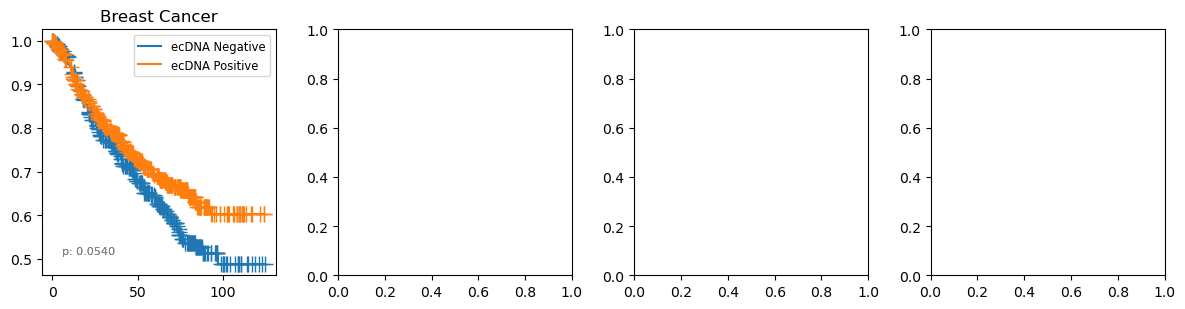

In [35]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])
cancer_types = crosstab_cancerType.index.tolist()

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 2 + 1.2 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['ecDNAStatus'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
        # labels
        if status == True :
            status = "ecDNA Positive"
        else :
            status = "ecDNA Negative"
        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
    
        # Get p value
        try :
            results = logrank_test(ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['osMonths'], 
                                    ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['osMonths'],
                                    event_observed_A=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == True]['vitalStatus_tf'], 
                                    event_observed_B=ecDNA_patient_specific[ecDNA_patient_specific['ecDNAStatus'] == False]['vitalStatus_tf'])
            if not results.p_value == np.nan :
                axs[i].text(0.2,0.1, f'p: {results.p_value:.4f}', horizontalalignment='center',
                    verticalalignment='center',
                    transform=axs[i].transAxes,
                    fontsize=8, 
                    color='grey')
        except :
            _ = 5
plt.tight_layout()
plt.show()

With amplification status

Using ECHO Amplifications


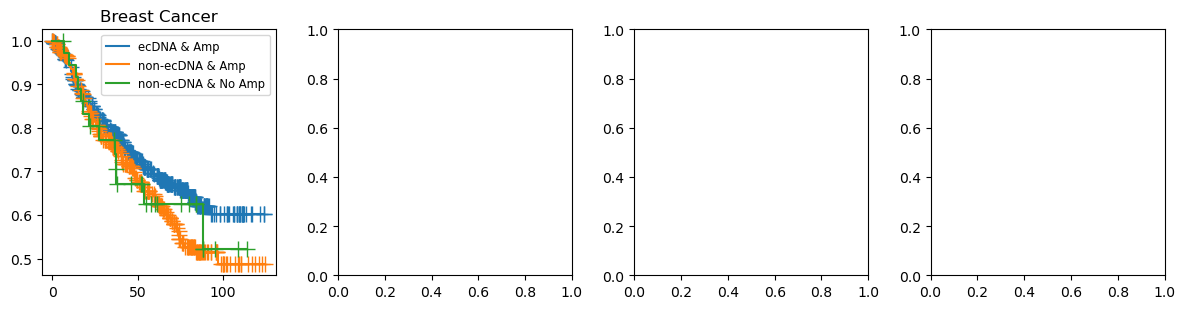

In [36]:
import warnings

print("Using ECHO Amplifications")
# Ignore all warnings
warnings.filterwarnings('ignore')

cancer_types = crosstab_cancerType.index.tolist()

ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])

# Allow for multiple plots
fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 2 + 1.2 * len(cancer_types)))
axs = axs.flatten()
for i in range(len(cancer_types)) :
    # Get specific data set for the cancer type
    ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
    ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)

    for status in sorted(ecDNA_patient_specific['combined_status'].unique()):

        kmf = KaplanMeierFitter()
        subset = ecDNA_patient_specific[ecDNA_patient_specific['combined_status'] == status]
        kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))

        kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
        axs[i].legend(loc='upper right', fontsize='small')

        axs[i].set_title(cancer_types[i])
        axs[i].set_xlabel("")
plt.tight_layout()
plt.show()

In [37]:
import warnings
if use_facets :

    
    print("Using FACETS Amplifications")
    # Ignore all warnings
    warnings.filterwarnings('ignore')
    
    cancer_types = crosstab_cancerType.index.tolist()
    
    ecDNA_patient_nona = ecDNA_patient.dropna(subset = ['ecDNAStatus', 'vitalStatus', 'osMonths', analysis_type])
    
    # Allow for multiple plots
    fig, axs = plt.subplots((len(cancer_types)+3)//4, 4, figsize = (12, 2 + 1.2 * len(cancer_types)))
    axs = axs.flatten()
    for i in range(len(cancer_types)) :
        # Get specific data set for the cancer type
        ecDNA_patient_specific = ecDNA_patient_nona[ecDNA_patient_nona[analysis_type] == cancer_types[i]]
        ecDNA_patient_specific['vitalStatus_tf'] = (ecDNA_patient_specific['vitalStatus'] == 'DECEASED').astype(int)
    
        for status in sorted(ecDNA_patient_specific['facets_combined_status'].unique()):
    
            kmf = KaplanMeierFitter()
            subset = ecDNA_patient_specific[ecDNA_patient_specific['facets_combined_status'] == status]
            kmf.fit(subset['osMonths'], event_observed=(subset['vitalStatus'] == 'DECEASED'))
    
            kmf.plot(show_censors=True, ci_show=False, label=f'{status}', ax = axs[i])
            axs[i].legend(loc='upper right', fontsize='small')
    
            axs[i].set_title(cancer_types[i])
            axs[i].set_xlabel("")
    plt.tight_layout()
    plt.show()

### Hazard Ratio Analysis

Cox model

In [38]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print(cox.summary)

                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus -0.241794   0.785218  0.125808       -0.488373        0.004785   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
ecDNAStatus             0.613624             1.004797     0.0 -1.921927   

                    p  -log2(p)  
covariate                        
ecDNAStatus  0.054615   4.19456  


With amplification status

In [39]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type, 'oncogeneAmp'])
# Change to 1 or 0
ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)
ecDNA_patient_cox['ampOccurred'] = (ecDNA_patient_cox['oncogeneAmp'] == 'Amp').astype(int)

from lifelines import CoxPHFitter

cox = CoxPHFitter()
covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus', 'ampOccurred']
cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
print("Using ECHO Amplifications")
print(cox.summary)

Using ECHO Amplifications
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
ecDNAStatus -0.245414   0.782381  0.129217       -0.498674        0.007847   
ampOccurred  0.035350   1.035982  0.292553       -0.538043        0.608743   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
ecDNAStatus             0.607335             1.007878     0.0 -1.899236   
ampOccurred             0.583890             1.838119     0.0  0.120833   

                    p  -log2(p)  
covariate                        
ecDNAStatus  0.057533  4.119455  
ampOccurred  0.903823  0.145887  


In [40]:
import warnings
if use_facets :
    # Ignore all warnings
    warnings.filterwarnings('ignore')
    
    ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type, 'oncogeneAmp'])
    # Change to 1 or 0
    ecDNA_patient_cox['eventOccurred'] = (ecDNA_patient_cox['vitalStatus'] == 'DECEASED').astype(int)
    ecDNA_patient_cox['ampOccurred'] = (ecDNA_patient_cox['facetsAmp'] == 'Amp').astype(int)
    
    from lifelines import CoxPHFitter
    
    cox = CoxPHFitter()
    covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus', 'ampOccurred']
    cox.fit(ecDNA_patient_cox[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
    print("Using FACETS Amplifications")
    print(cox.summary)

In [41]:
import warnings
warnings.filterwarnings("ignore")

ecDNA_patient_cox = ecDNA_patient.dropna(subset = ['osMonths', 'ecDNAStatus', analysis_type])
from lifelines import CoxPHFitter

cox_df = pd.DataFrame(columns = ['ctype', 'p_value', 'hazardRatio', 'upper', 'lower'])

# Create a dataframe for cox model output for each cancer type
for ctype in crosstab_cancerType.index.tolist() :
    try :
        ecDNA_patient_cox_specific = ecDNA_patient_cox[ecDNA_patient_cox[analysis_type] == ctype]
        ecDNA_patient_cox_specific['eventOccurred'] = (ecDNA_patient_cox_specific['vitalStatus'] == 'DECEASED').astype(int)

        cox = CoxPHFitter()
        covariates = ['osMonths', 'eventOccurred', 'ecDNAStatus']
        cox.fit(ecDNA_patient_cox_specific[covariates], duration_col = 'osMonths', event_col = 'eventOccurred')
        new_row = {
            'ctype' : ctype,
            'p_value' : cox.summary['p'][0],
            'hazardRatio' : cox.summary['exp(coef)'][0],
            'upper' : cox.summary['exp(coef) upper 95%'][0],
            'lower' : cox.summary['exp(coef) lower 95%'][0]
        }
        new_df = pd.DataFrame([new_row])
        cox_df = pd.concat([cox_df, new_df], ignore_index = True)

    except :
        print(f"{ctype}: Convergence Not Found")

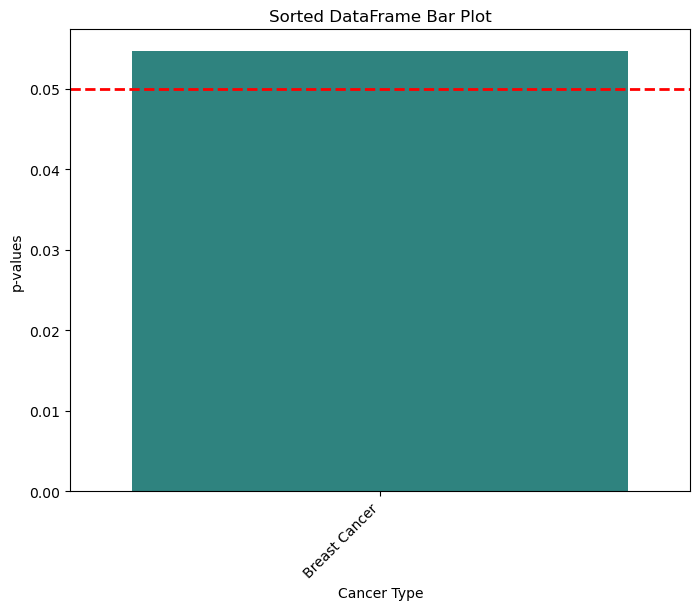

In [42]:
import seaborn as sns

cox_df = cox_df.sort_values(by='p_value')
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='ctype', y='p_value', data=cox_df, palette='viridis')
plt.xlabel('Cancer Type')
plt.ylabel('p-values')
plt.title('Sorted DataFrame Bar Plot')
bars.set_xticklabels(bars.get_xticklabels(), rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2)

plt.show()

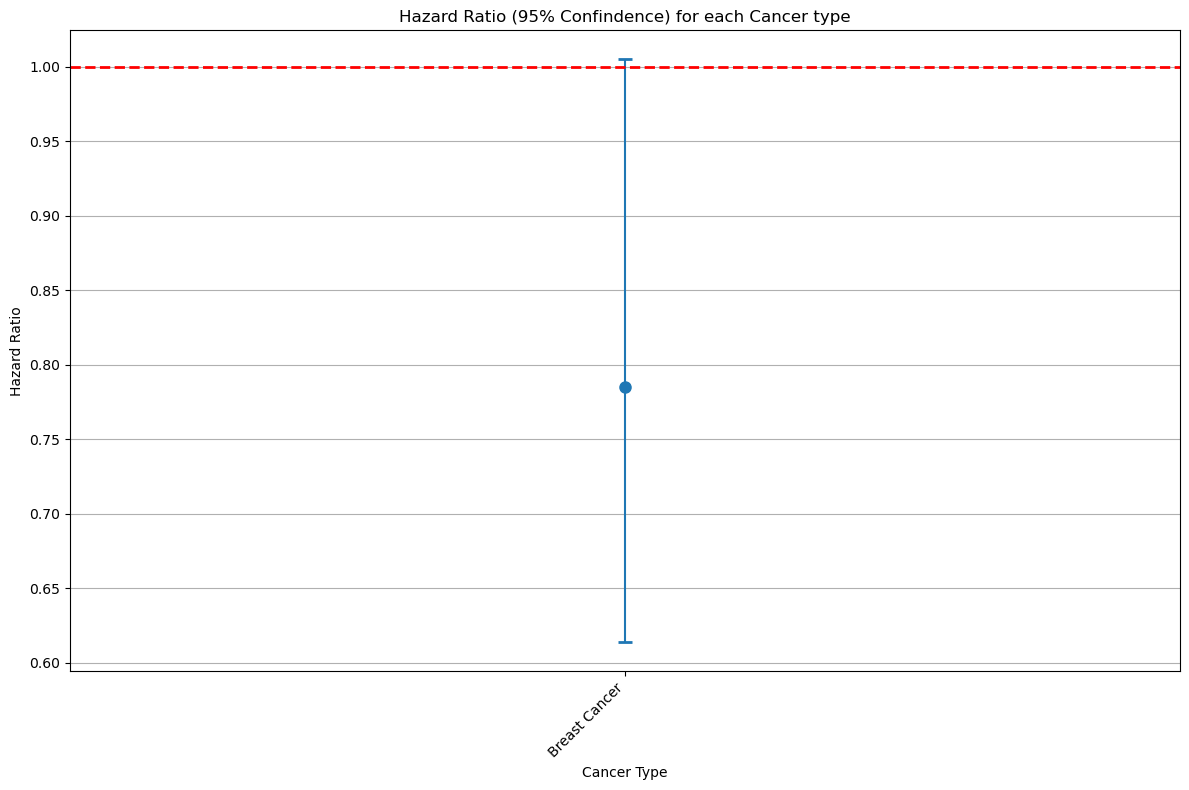

In [43]:
non_zero = cox_df[cox_df['lower'] != 0]

# Number of rows in the DataFrame
num_rows = non_zero.shape[0]

# Plotting points with error bars for each row
plt.figure(figsize=(12, 8))

# Plot points
positions = np.arange(num_rows)
plt.errorbar(positions, non_zero['hazardRatio'], yerr=[non_zero['hazardRatio'] - non_zero['lower'], non_zero['upper'] - non_zero['hazardRatio']],
             fmt='o', markersize=8, capsize=5, capthick=2)

# Set x-axis ticks and labels
plt.xlabel('Cancer Type')
plt.xticks(positions, non_zero['ctype'],rotation=45, ha='right')


# Add labels and title
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratio (95% Confindence) for each Cancer type')
plt.axhline(y=1, color='r', linestyle='--', linewidth=2)

plt.grid(True, axis='y')  # Add grid lines for better visualization
plt.tight_layout()
plt.show()

### Gene Level

In [44]:
# Count the number of times each gene is called
gene_called_nonecDNA_count = {}
gene_ecDNA_count = {}

for idx, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['gene'] in gene_ecDNA_count :
            gene_ecDNA_count[row['gene']] += 1
        else :
            gene_ecDNA_count[row['gene']] = 1
        if not row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] = 0
    elif row['ecDNA_status'] == 'non-ecDNA' :
        if row['gene'] in gene_called_nonecDNA_count :
            gene_called_nonecDNA_count[row['gene']] += 1
        else :
            gene_called_nonecDNA_count[row['gene']] = 1




Get IMPACT Lists for correction

In [45]:
# These should be in the notebook directory
im3 = pd.read_excel("./IMPACT341-Gene-List_20140101.xlsx")
im3_genes = set(im3['Gene_Symbol'].unique())

im5 = pd.read_excel("./IMPACT410-Gene-List_20150201.xlsx")
im5_genes = set(im5['Gene_Symbol'].unique())

im6 = pd.read_excel("./impact-genes-468.xlsx")
im6_genes = set(im6['Approved Symbol'].unique())

im7 = pd.read_excel("./IMPACT505_Gene_list_detailed.xlsx", header = None)
im7_genes = set()
for column in im7.columns:
    im7_genes.update(im7[column].unique())
im7_genes.remove(np.nan)

In [46]:
# Count the number of samples in each 
number_im3 = 0
number_im5 = 0
number_im6 = 0
number_im7 = 0
# number_ih3 = 0
# number_ih4 = 0

for sample in echo['sampleId'].unique() :
    try :
        if sample[-3:] == "IM3" :
            number_im3 += 1
        elif sample[-3:] == "IM5" :
            number_im5 += 1
        elif sample[-3:] == "IM6" :
            number_im6 += 1
        elif sample[-3:] == "IM7" :
            number_im7 += 1
        # elif sample[-3:] == "IH3" :
        #     number_ih3 += 1
        # elif sample[-3:] == "IH4" :
        #     number_ih4 += 1
    except :
        print(f"Warning: {sample}")

print(f"IM3: {number_im3}")
print(f"IM5: {number_im5}")
print(f"IM6: {number_im6}")
print(f"IM7: {number_im7}")
# print(f"IH3: {number_ih3}")
# print(f"IH4: {number_ih4}")

IM3: 59
IM5: 144
IM6: 516
IM7: 290


Plot top genes

In [47]:
gene_ecDNA_percentages = {}

def change_gene(gene) :
    new_gene = gene
    # These have alternate names that are used
    conversion_dict = {"NSD3" : "WHSC1L1", "ELOC" : "TCEB1", "H2BC5" : "HIST1H2BD", "ABRAXAS1" : "FAM175A", "MYCL" : "MYCL1", "H3-3B" : "H3F3B", "H3C6" : "HIST1H3E", "H1-2" : "HIST1H1C", "PRKN" : "PARK2"}
    if new_gene in conversion_dict :
        new_gene = conversion_dict[new_gene]
    new_gene = [new_gene]
    if "RAD51D" in new_gene :
        new_gene.append("RAD51L3")

    return new_gene

for gene in gene_ecDNA_count :
    new_genes = change_gene(gene)    
    # Tally number for each gene
    total_num = 0
    for new_gene in new_genes :
        if new_gene in im3_genes :
            total_num += number_im3
        if new_gene in im5_genes :
            total_num += number_im5
        if new_gene in im6_genes :
            total_num += number_im6
        if new_gene in im7_genes :
            total_num += number_im7

    # Default to max number
    if total_num < 3 :
        print(f"{gene} Not Found. Using {len(echo['tumorSampleId'].unique())}")
        total_num = len(echo['tumorSampleId'].unique())
    gene_ecDNA_percentages[gene] = gene_ecDNA_count[gene]/total_num


CD44 Not Found. Using 1009
IKZF3 Not Found. Using 1009
STAT6 Not Found. Using 1009
EWSR1 Not Found. Using 1009
ROBO1 Not Found. Using 1009
SETBP1 Not Found. Using 1009


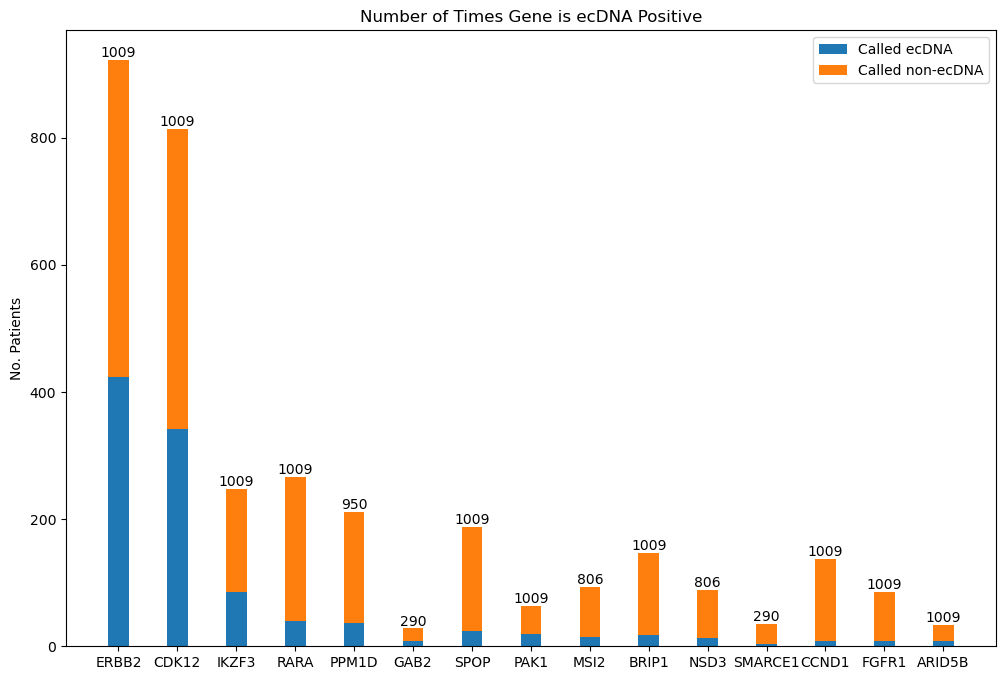

In [48]:
# Pick out top 15 from sorted proportion of ecDNA positive
gene_ecDNA_top15 = dict(sorted(gene_ecDNA_percentages.items(), key=lambda x: x[1], reverse=True)[:15])

keys = gene_ecDNA_top15.keys()
ecDNA_neg = [gene_called_nonecDNA_count[key] for key in keys]
ecDNA_pos = [gene_ecDNA_count[key] for key in keys]

ind = np.arange(len(keys))
width = 0.35

plt.figure(figsize = (12, 8))
p1 = plt.bar(ind, ecDNA_pos, width)
p2 = plt.bar(ind, ecDNA_neg, width, bottom=ecDNA_pos)

for i, value in enumerate(gene_ecDNA_top15) :
    # Change gene names
    values = change_gene(value)

    # Put labels for each which are the number of samples the gene was queried in
    total_num = 0
    for value in values :
        if value in im3_genes :
            total_num += number_im3
        if value in im5_genes :
            total_num += number_im5
        if value in im6_genes :
            total_num += number_im6
        if value in im7_genes :
            total_num += number_im7
        if total_num < 3 :
            total_num = len(echo['tumorSampleId'].unique())
    plt.text(i, ecDNA_neg[i] + ecDNA_pos[i], str(total_num), ha = 'center', va = 'bottom')

plt.ylabel('No. Patients')
plt.title('Number of Times Gene is ecDNA Positive')
plt.xticks(ind, keys)
plt.legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

plt.show()

Which cancers did these genes come from?

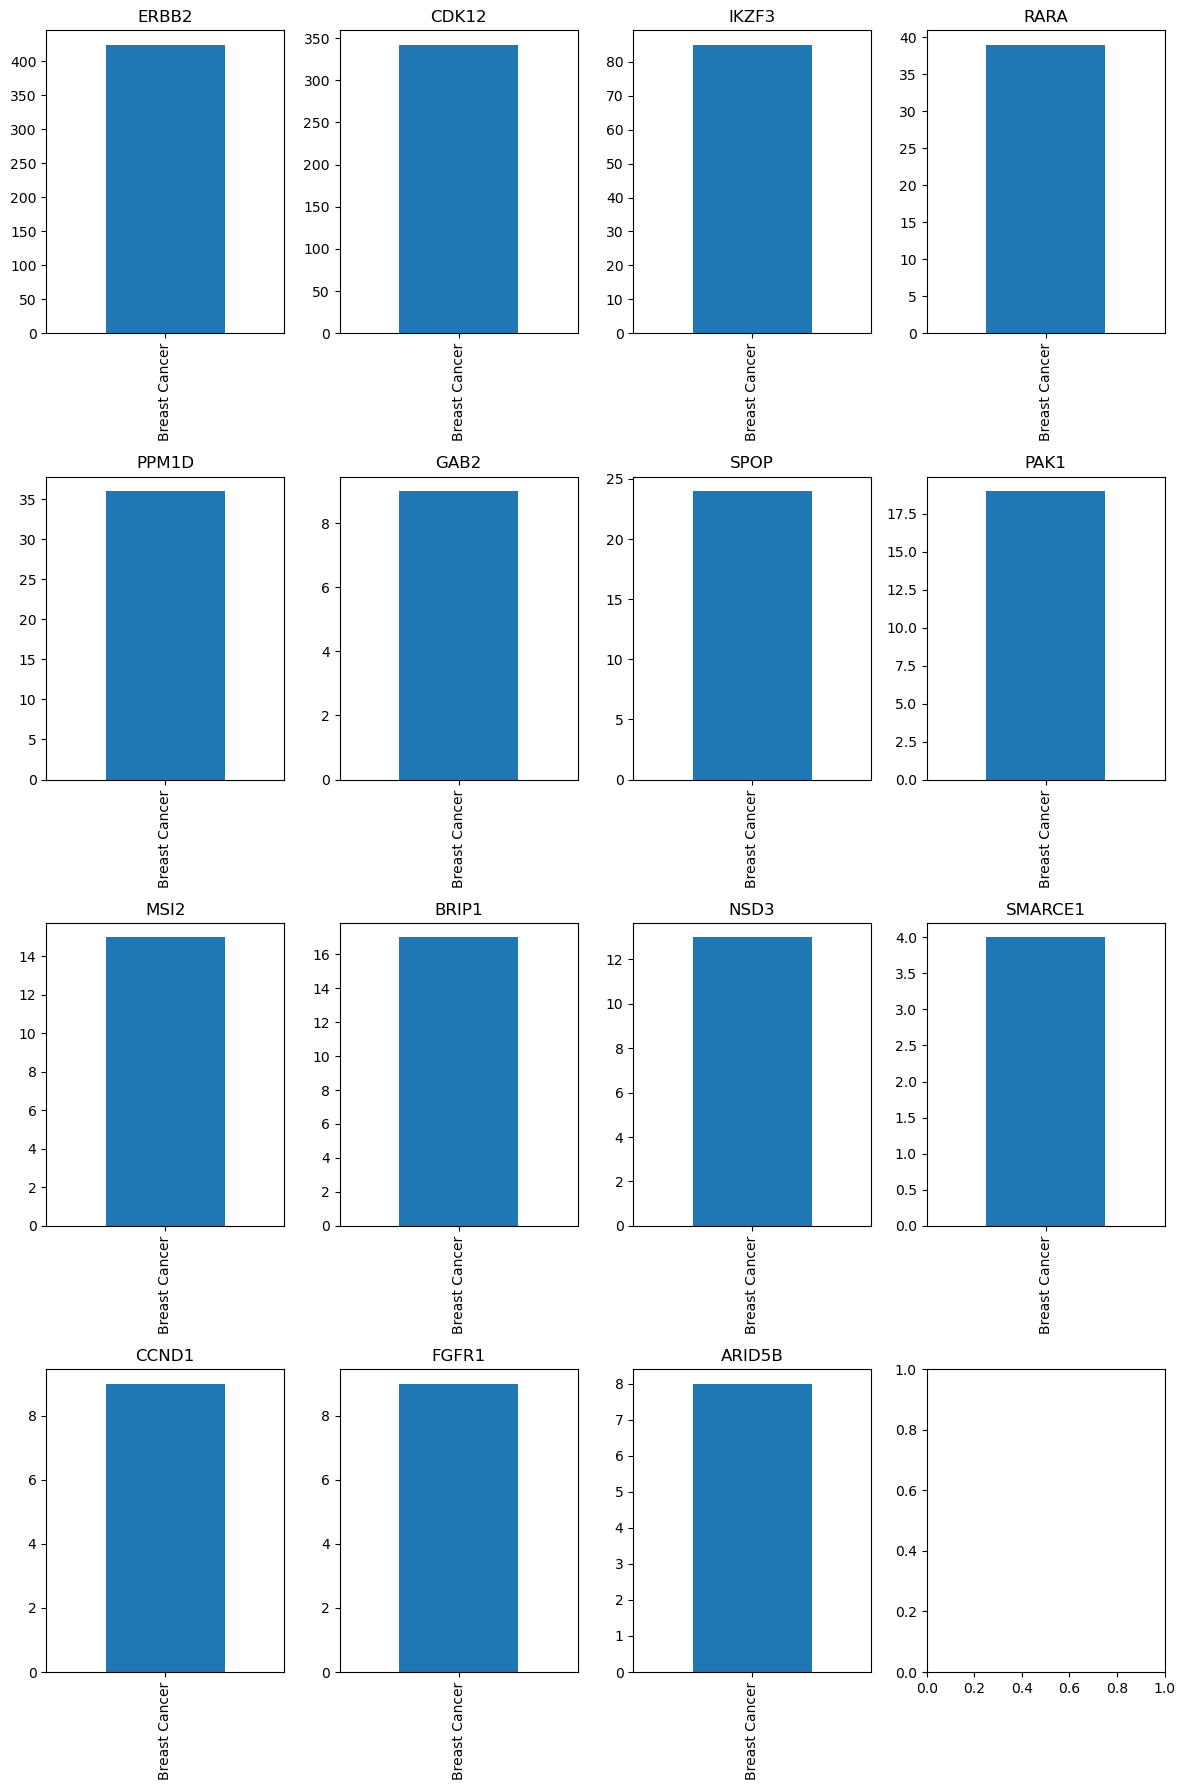

In [49]:
fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Normalized by counts of each cancer (patient wise)

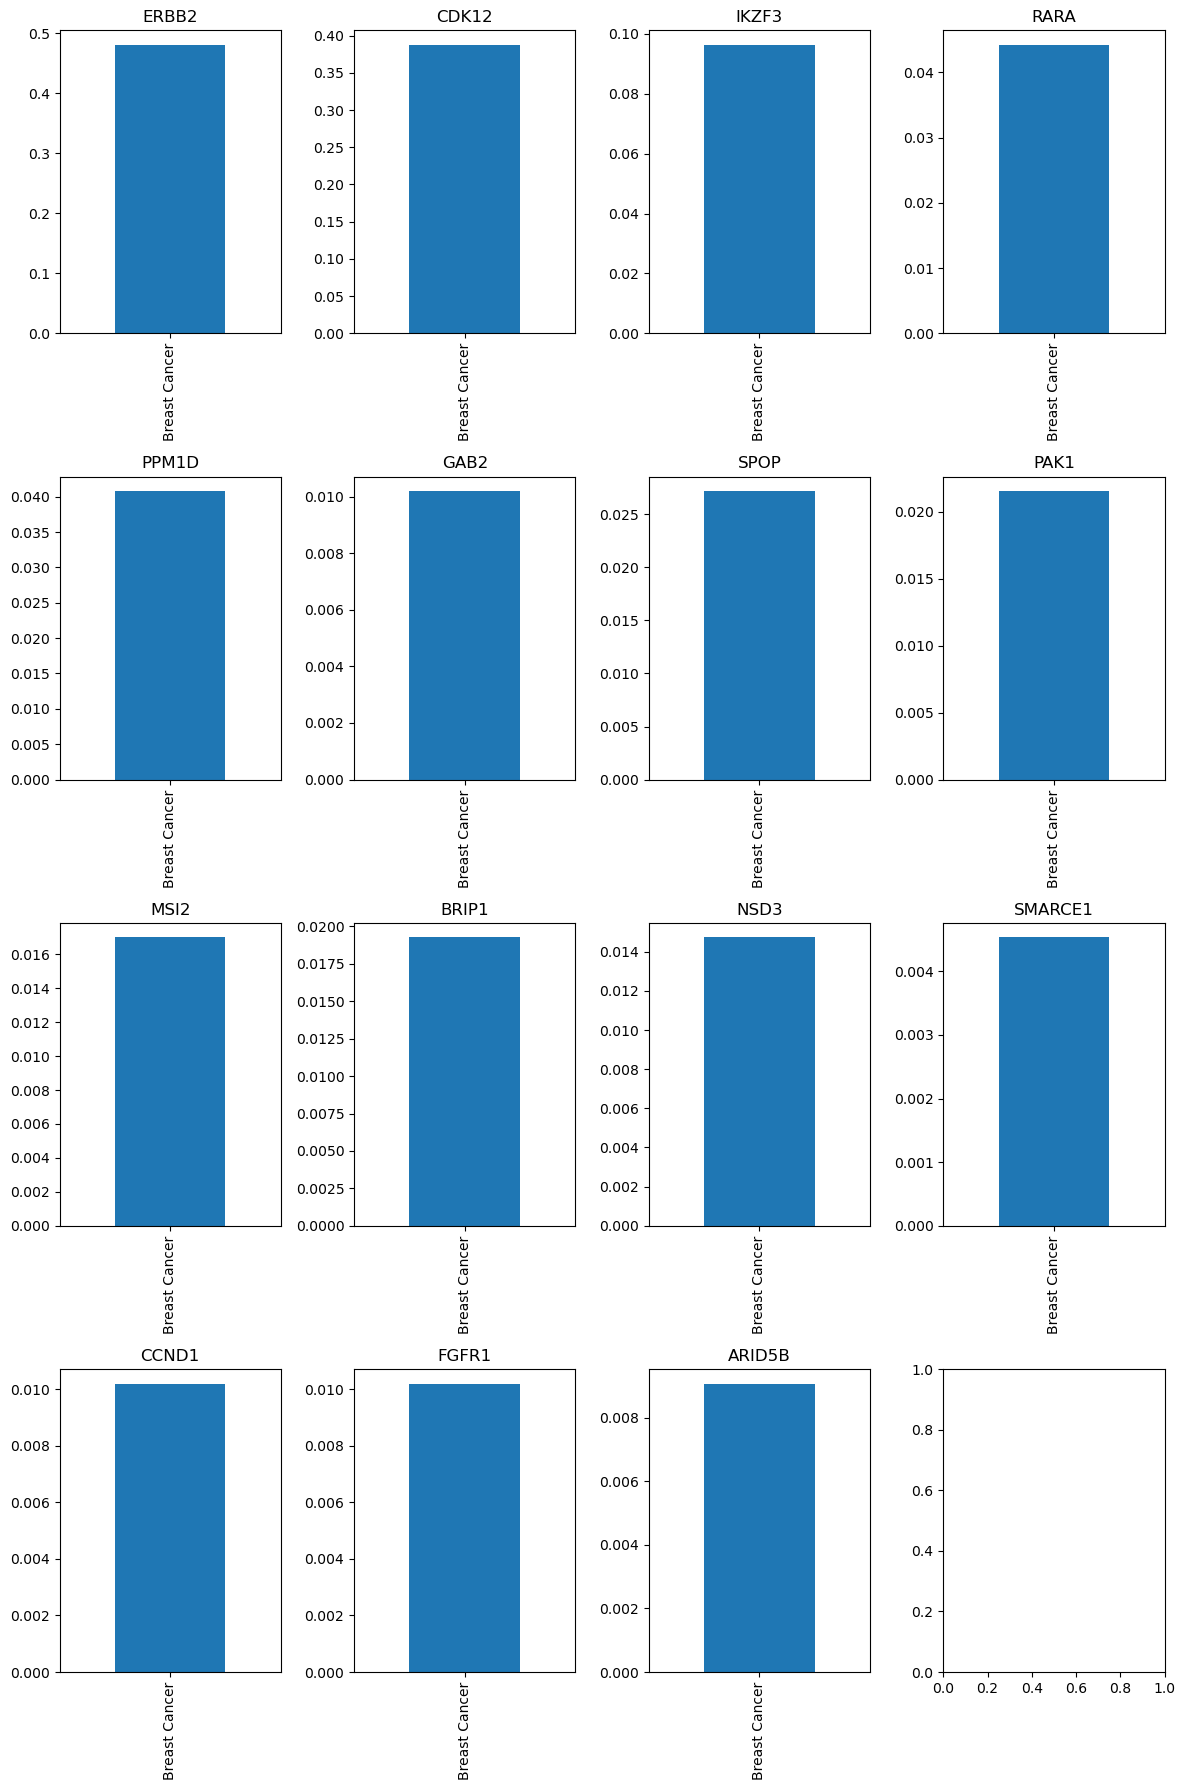

In [50]:
cancerCounts = {}
for i, row in ecDNA_patient.iterrows() :
        if row[analysis_type] in cancerCounts :
                cancerCounts[row[analysis_type]] += 1
        else :
                cancerCounts[row[analysis_type]] = 1

fig, axs = plt.subplots((len(gene_ecDNA_top15)+3)//4, 4, figsize = (12, 1.2 * len(gene_ecDNA_top15)))
axs = axs.flatten()

for i, gene in enumerate(gene_ecDNA_top15) :
        subset = echo[echo['gene'] == gene]
        subset = subset[subset['ecDNA_status'] == 'ecDNA']
        
        counts = subset[analysis_type].value_counts()
        counts = counts / counts.index.map(cancerCounts)
        counts.plot(kind = 'bar', ax = axs[i])
        axs[i].set_title(gene)
        axs[i].set_xlabel('')
fig.tight_layout()



Genes for specific cancers

In [51]:
ctype_dicts = []
ctype_non_dicts = []
cancers_with_ecDNA = []
for ctype in cancer_types :
    ctype_dict = {}
    ctype_non_dict = {}
    for i, row in echo.iterrows() :
        if row[analysis_type] == ctype :
            if row['ecDNA_status'] == 'ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_dict :
                        ctype_dict[row['gene']] = 1
                    else :
                        ctype_dict[row['gene']] += 1
            if row['ecDNA_status'] == 'non-ecDNA' :
                if isinstance(row['gene'], str) :
                    if not row['gene'] in ctype_non_dict :
                        ctype_non_dict[row['gene']] = 1
                    else :
                        ctype_non_dict[row['gene']] += 1
    if len(ctype_dict) > 0 :
        ctype_dicts.append(ctype_dict)
        ctype_non_dicts.append(ctype_non_dict)
        cancers_with_ecDNA.append(ctype)

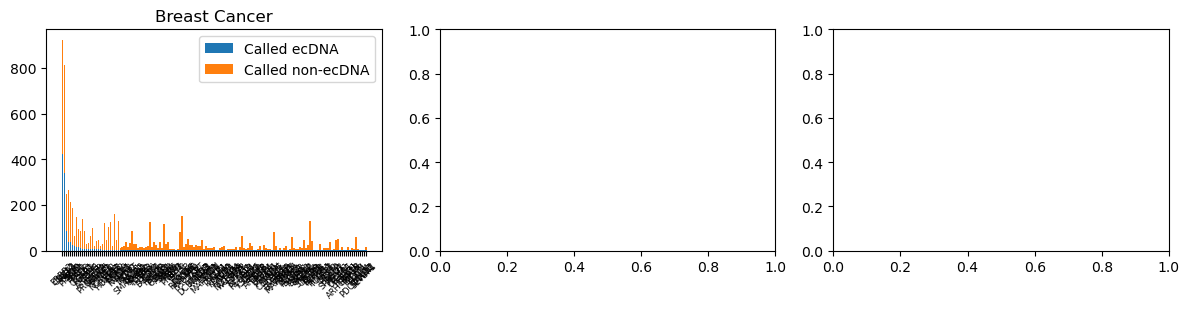

In [52]:
fig, axs = plt.subplots((len(cancers_with_ecDNA)+2)//3, 3, figsize = (12, 2 + 1.2 * len(cancers_with_ecDNA)))
axs = axs.flatten()

for i, ctype in enumerate(cancers_with_ecDNA) :
        labels = list(ctype_dicts[i].keys())
        values_dict1 = [ctype_dicts[i].get(label, 0) for label in labels]
        values_dict2 = [ctype_non_dicts[i].get(label, 0) for label in labels]
    
        # Combine the lists into a list of tuples
        combined = list(zip(values_dict1, values_dict2, labels))
        
        # Sort the combined list by the first element (elements of list1)
        sorted_combined = sorted(combined, key=lambda x: x[0], reverse = True)
        
        # Unzip the sorted list back into individual lists
        values_dict1, values_dict2, labels = zip(*sorted_combined)
    
        axs[i].bar(labels, values_dict1)
        axs[i].bar(labels, values_dict2, bottom = values_dict1)

        axs[i].set_title(ctype)
        axs[i].set_xticklabels(labels, rotation=45, fontsize=6)
        axs[i].set_xlabel('')
        axs[i].legend((p1[0], p2[0]), ('Called ecDNA', 'Called non-ecDNA'))

fig.tight_layout()



### Segment Size from FACETS Results

In [53]:
if use_facets :
    facets_seq_length = facets.dropna(subset = ['seg_length'])
    
    # Build a dictionary for ecDNA
    ecDNA_gene_dict = {}
    for i, row in echo.iterrows() :
        if row['ecDNA_status'] == 'ecDNA' :
            to_hash = row['tumorSampleId'] + '_' + row['gene']
            ecDNA_gene_dict[to_hash] = True
    
    # Fill in facets column
    facets_seq_length['ecDNA'] = 'non-ecDNA'
    facets_seq_length['amped'] = False
    
    for i, row in facets_seq_length.iterrows() :
        to_hash = row['sample'] + '_' + row['gene']
        if to_hash in ecDNA_gene_dict :
            facets_seq_length.loc[i, 'ecDNA'] = 'ecDNA'
        if "AMP" in row['cn_state'] or "GAIN" in row['cn_state'] :
            facets_seq_length.loc[i, 'amped'] = True


In [54]:
if use_facets :

    facets_amp = facets_seq_length[facets_seq_length['amped'] == True]
    
    # Define colors for each category
    color_map = {'ecDNA': 'sandybrown', 'non-ecDNA': 'steelblue'}
    
    # Create a list of colors based on the 'ecDNA' column
    colors = facets_amp['ecDNA'].map(color_map)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(facets_amp['seg_length'], facets_amp['tcn'], c=colors, label=facets_amp['ecDNA'], alpha = 0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Copy Numnber')
    plt.xlabel('Segment Length')
    plt.title("Copy Number vs Segment Length for Amplified Genes")
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = ['sandybrown', 'steelblue']
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

In [55]:
if use_facets :

    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['tcn']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['tcn']
    log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Copy Number for Amplified Genes')
    plt.xlabel('Copy Number (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = ['sandybrown', 'steelblue']
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')


In [56]:
if use_facets :
    
    # Separate data for ecDNA and non-ecDNA
    ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'ecDNA']['seg_length']
    log_ecDNA = [math.log10(x) for x in ecDNA_facets_amp]
    
    non_ecDNA_facets_amp = facets_amp[facets_amp['ecDNA'] == 'non-ecDNA']['seg_length']
    log_non_ecDNA = [math.log10(x) for x in non_ecDNA_facets_amp]
    
    # Plotting histograms on logarithmic scale
    plt.figure(figsize=(10, 6))
    bins = np.linspace(min(log_ecDNA + log_non_ecDNA), max(log_ecDNA + log_non_ecDNA),30)
    # Histogram for ecDNA = ecDNA
    plt.hist(log_ecDNA, alpha=0.5, bins = bins, color='sandybrown', label='ecDNA', density = True)
    
    # Histogram for ecDNA = non-ecDNA
    plt.hist(log_non_ecDNA,  alpha=0.5, bins = bins, color='steelblue', label='non-ecDNA', density = True)
    
    # Customize the plot
    plt.title('Distribution of Segment Length for Amplified Genes')
    plt.xlabel('Segment Length (log)')
    plt.ylabel('Proportion')
    
    legend_labels = ['ecDNA', 'non-ecDNA']
    legend_colors = ['sandybrown', 'steelblue']
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in legend_colors]
    plt.legend(markers, legend_labels, loc='upper right')

### ecDNA Co-occurance + Correlations

Text(0, 0.5, 'No. Samples')

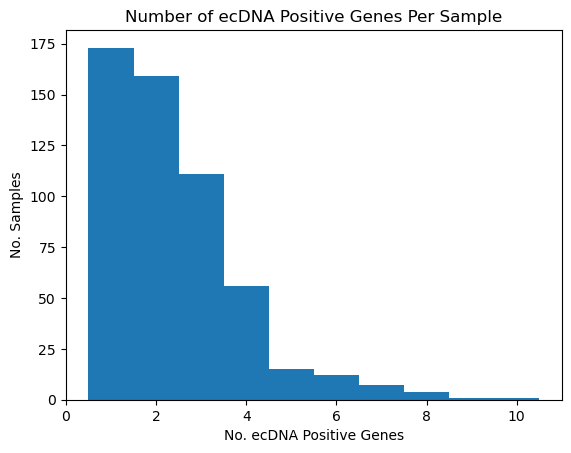

In [57]:
# Dict of ecDNA counts
ecDNA_count_per_patient = {}
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if row['sampleId'] in ecDNA_count_per_patient :
            ecDNA_count_per_patient[row['sampleId']] += 1
        else :
            ecDNA_count_per_patient[row['sampleId']] = 1

# Create a histogram
patient_counts = ecDNA_count_per_patient.values()
plt.hist(patient_counts, bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5])
plt.title("Number of ecDNA Positive Genes Per Sample")
plt.xlabel("No. ecDNA Positive Genes")
plt.ylabel("No. Samples")

In [58]:
# Create a sample level dataframe

echo_sample = manifest
echo_sample['ecDNA_status'] = 'NA'
echo_sample['echo_amp'] = 'NA'
echo_sample['combined'] = 'NA'

# First make a dict
echo_sample_idx = {}
for i, row in echo_sample.iterrows() :
    echo_sample_idx[row['sampleId']] = i

# Fill in echo amplification status
for i, row in echo.iterrows() :
    if row['tumorSampleId'] not in echo_sample_idx :
        print(f'{row['tumorSampleId']} Not Found')
    else :
        if row['ecDNA_status'] == 'ecDNA' :
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'ecDNA'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'amp'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'ecDNA & Amp'

        elif row['ecDNA_status'] == 'non-ecDNA' :
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] == 'ecDNA' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'non-ecDNA'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'amp'
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] == 'ecDNA & Amp' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'No ecDNA & Amp'
                
        else :
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] == 'ecDNA' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'ecDNA_status'] = 'non-ecDNA'
            if not echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] == 'amp' :
                echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'echo_amp'] = 'non-amp'
            echo_sample.loc[echo_sample_idx[row['tumorSampleId']], 'combined'] = 'No ecDNA & No Amp'


In [59]:
# Make tumor burden categorical
cutoffs = [4, 0.2, 2.5]
echo_sample['tumorBurdenHigh'] = np.nan
echo_sample['fractionAlteredHigh'] = np.nan
echo_sample['msiInstability'] = np.nan
for i, row in echo_sample.iterrows() :
    if not np.isnan(row['tumorBurdenScore']) :
        if row['tumorBurdenScore'] >= cutoffs[0] :
            echo_sample.loc[i, 'tumorBurdenHigh'] = 'High'
        else :
            echo_sample.loc[i, 'tumorBurdenHigh'] = 'Low'
    if not np.isnan(row['fractionAltered']) :
        if row['fractionAltered'] >= cutoffs[1] :
            echo_sample.loc[i, 'fractionAlteredHigh'] = 'High'
        else :
            echo_sample.loc[i, 'fractionAlteredHigh'] = 'Low'
    if not np.isnan(row['msiScore']) :
        if row['msiScore'] >= cutoffs[2] :
            echo_sample.loc[i, 'msiInstability'] = 'High'
        else :
            echo_sample.loc[i, 'msiInstability'] = 'Low'

In [60]:
echo_sample_primary = echo_sample[echo_sample['sampleType'].isin(['Primary', 'Local Recurrence'])]
echo_sample_met = echo_sample[echo_sample['sampleType'] == 'Metastasis']

# Filter
echo_sample_primary = echo_sample_primary[echo_sample_primary['combined'] != 'NA']
echo_sample_met = echo_sample_met[echo_sample_met['combined'] != 'NA']

In [61]:
from scipy.stats import chi2_contingency

categorical_columns = ['fractionAlteredHigh', 'tumorBurdenHigh', 'msiInstability']
sample_types = ['No ecDNA & No Amp', 'No ecDNA & Amp', 'ecDNA & Amp']
convert_status = {'No ecDNA & No Amp' : 'No Amp', 'No ecDNA & Amp' : 'Amp', 'ecDNA & Amp' : 'ecDNA'}

def get_chi2_results(echo_sample_type) :
    results = []
    for cat in categorical_columns:
        for i, status1 in enumerate(sample_types):
            for status2 in sample_types[i+1:]:
                to_use = echo_sample_type[echo_sample_type['combined'].isin([status1, status2])]
                # Create a contingency table
                to_use = to_use[to_use[cat].isin(['High', 'Low'])]
                table = pd.crosstab(to_use['combined'], to_use[cat])
    
                # Calculate correlation of 'high'
                try : 
                    if (table['High'][status1] / (table['Low'][status1] + table['High'][status1])) > (table['High'][status2] / (table['Low'][status2] + table['High'][status2])) :
                        more_correlated = status1
                    elif (table['High'][status1] / (table['Low'][status1] + table['High'][status1])) < (table['High'][status2] / (table['Low'][status2] + table['High'][status2])) :
                        more_correlated = status2
                    else :
                        more_correlated = "Neither"
                except :
                        more_correlated = "Neither"
    
                    
                chi2, p, _, _ = chi2_contingency(table)
                results.append({
                    'Comparison': f'{convert_status[status1]} vs {convert_status[status2]}',
                    'Category': cat,
                    'Chi2': chi2,
                    'P-value': p,
                    'More Correlated with High': convert_status[more_correlated]
    
                })
    return results

primary_results = pd.DataFrame(get_chi2_results(echo_sample_primary))
met_results = pd.DataFrame(get_chi2_results(echo_sample_met))



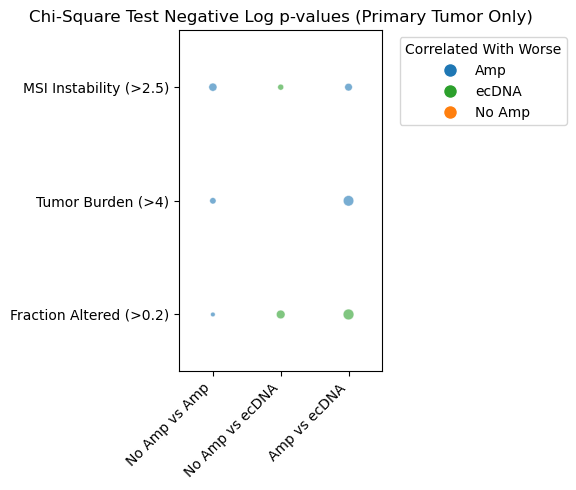

In [62]:
scale = 100
primary_results['Bubble Size'] = -np.log10(primary_results['P-value']) * scale  # Adjust multiplier for better visibility

color_map = {
    'Amp': '#1f77b4',  # Blue
    'ecDNA': '#2ca02c',     # Green
    'No Amp': '#ff7f0e' # Orange
}

fig, ax = plt.subplots(figsize=(6, 5))

scatter = plt.scatter(
    primary_results['Comparison'], 
    primary_results['Category'], 
    s=primary_results['Bubble Size'], 
    alpha=0.6, 
    c=primary_results['More Correlated with High'].map(color_map),  # Map colors based on category
    cmap='viridis',  # Color map
    edgecolors='w', 
    linewidth=0.5
)

highlight = primary_results[primary_results['P-value'] < 0.05]
ax.scatter(
    highlight['Comparison'], 
    highlight['Category'], 
    s=-np.log10(0.05) * scale, 
    facecolors='none',  # Transparent fill
    edgecolors='red',     # Red edge
    linewidth=1.5       # Width of the ring
)

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_map.items()]
ax.legend(handles=handles, title='Correlated With Worse', bbox_to_anchor=(1.05, 1), loc='upper left')


# Set x-axis labels to be diagonal
ax.set_xticklabels(primary_results['Comparison'], rotation=45, ha='right')

# Add custom y-axis labels if needed
custom_y_labels = [f'Fraction Altered (>{cutoffs[1]})', f'Tumor Burden (>{cutoffs[0]})', f'MSI Instability (>{cutoffs[2]})']
ax.set_yticks(list(primary_results['Category'].unique()))
ax.set_yticklabels(custom_y_labels)

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Chi-Square Test Negative Log p-values (Primary Tumor Only)')

# Adjust plot limits and spacing for better point centering
ax.set_xlim([-0.5, len(primary_results['Comparison'].unique()) - 0.5])
ax.set_ylim([-0.5, len(custom_y_labels) - 0.5])
plt.tight_layout()


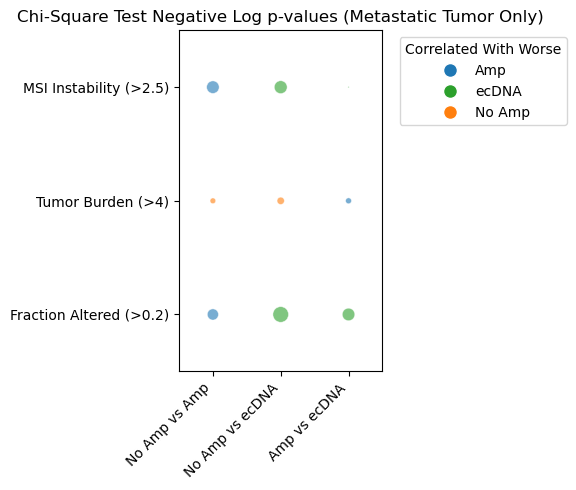

In [63]:
scale = 100
met_results['Bubble Size'] = -np.log10(met_results['P-value']) * scale  # Adjust multiplier for better visibility

color_map = {
    'Amp': '#1f77b4',  # Blue
    'ecDNA': '#2ca02c',     # Green
    'No Amp': '#ff7f0e' # Orange
}

fig, ax = plt.subplots(figsize=(6, 5))

scatter = plt.scatter(
    met_results['Comparison'], 
    met_results['Category'], 
    s=met_results['Bubble Size'], 
    alpha=0.6, 
    c=met_results['More Correlated with High'].map(color_map),  # Map colors based on category
    cmap='viridis',  # Color map
    edgecolors='w', 
    linewidth=0.5
)

highlight = met_results[met_results['P-value'] < 0.05]
ax.scatter(
    highlight['Comparison'], 
    highlight['Category'], 
    s=-np.log10(0.05) * scale, 
    facecolors='none',  # Transparent fill
    edgecolors='red',     # Red edge
    linewidth=1.5       # Width of the ring
)

# Add custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in color_map.items()]
ax.legend(handles=handles, title='Correlated With Worse', bbox_to_anchor=(1.05, 1), loc='upper left')


# Set x-axis labels to be diagonal
ax.set_xticklabels(met_results['Comparison'], rotation=45, ha='right')

# Add custom y-axis labels if needed
custom_y_labels = [f'Fraction Altered (>{cutoffs[1]})', f'Tumor Burden (>{cutoffs[0]})', f'MSI Instability (>{cutoffs[2]})']
ax.set_yticks(list(met_results['Category'].unique()))
ax.set_yticklabels(custom_y_labels)

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Chi-Square Test Negative Log p-values (Metastatic Tumor Only)')

# Adjust plot limits and spacing for better point centering
ax.set_xlim([-0.5, len(met_results['Comparison'].unique()) - 0.5])
ax.set_ylim([-0.5, len(custom_y_labels) - 0.5])
plt.tight_layout()


In [65]:
# Calculate proportions of ecDNA and non-ecDNA for each age
echo_combined = ecDNA_patient[ecDNA_patient['combined_status'] != 'NA']
bins = np.arange(0, 101, 10)
bin_labels = [bins[i] + 5 for i in range(len(bins)-1)]

# Group ages into bins with labels
echo_combined['Age_bin'] = pd.cut(echo_combined['deIDAge'], bins=bins, labels=bin_labels, right=False)

age_counts = echo_combined.groupby(['Age_bin', 'combined_status']).size().unstack(fill_value=0)
age_counts['total'] = age_counts.sum(axis=1)
age_counts['ecDNA_prop'] = age_counts['ecDNA & Amp'] / age_counts['total']
age_counts['non_ecDNA_Amp_prop'] = age_counts['non-ecDNA & Amp'] / age_counts['total']
age_counts['non_ecDNA_Non_Amp_prop'] = age_counts['non-ecDNA & No Amp'] / age_counts['total']

Text(0.5, 0, 'Age')

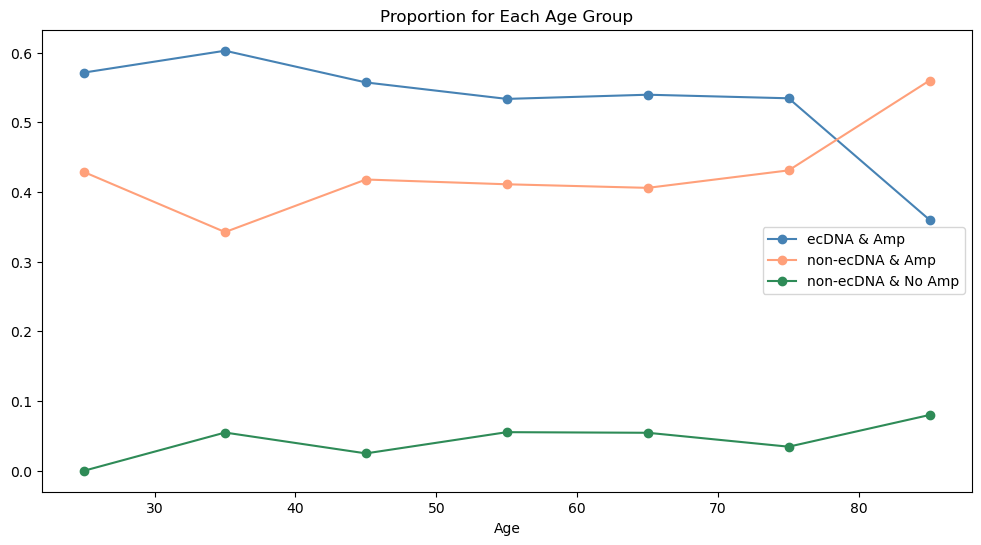

In [66]:
plt.figure(figsize=(12,6))
plt.plot(age_counts.index, age_counts['ecDNA_prop'], marker='o', linestyle='-', color='steelblue', label='ecDNA & Amp')
plt.plot(age_counts.index, age_counts['non_ecDNA_Amp_prop'], marker='o', linestyle='-', color='lightsalmon', label='non-ecDNA & Amp')
plt.plot(age_counts.index, age_counts['non_ecDNA_Non_Amp_prop'], marker='o', linestyle='-', color='seagreen', label='non-ecDNA & No Amp')
plt.legend()
plt.title("Proportion for Each Age Group")
plt.xlabel("Age")

In [67]:
crosstab_cancerType = pd.crosstab(echo_sample['combined'], echo_sample['stageHighest'], normalize = 'index')
crosstab_cancerType

stageHighest,Stage 1-3,Stage 4,Unknown
combined,,,
NA,0.577320,0.257732,0.164948
No ecDNA & Amp,0.595745,0.267139,0.137116
No ecDNA & No Amp,0.681818,0.227273,0.090909
ecDNA & Amp,0.546125,0.293358,0.160517


In [68]:
crosstab_cancerType = pd.crosstab(echo_sample['combined'], echo_sample['sampleType'], normalize = 'index')
crosstab_cancerType

sampleType,Local Recurrence,Metastasis,Primary,Unknown
combined,,,,
NA,0.000000,0.494845,0.237113,0.268041
No ecDNA & Amp,0.007092,0.510638,0.479905,0.002364
No ecDNA & No Amp,0.045455,0.477273,0.477273,0.000000
ecDNA & Amp,0.009225,0.500000,0.444649,0.046125


Co-occurence

In [69]:
# tracks which samples have what ecDNA positives
ecDNA_by_sample = {}

# indexes into a matrix, reverse
ecDNA_indexes = {}
# to track counts of ecDNA total for percentages
ecDNA_counts = {}
# tracker for index
ecDNA_index_curr = 0
for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if not row['gene'] in ecDNA_indexes :
            ecDNA_indexes[row['gene']] = ecDNA_index_curr
            ecDNA_index_curr += 1
            ecDNA_counts[row['gene']] = 1
        else :
            ecDNA_counts[row['gene']] += 1
reverse_ecDNA_indexes = {value: key for key, value in ecDNA_indexes.items()}


# co-occurence matrix
ecDNA_matrix = [[0 for _ in range(len(ecDNA_counts))] for _ in range(len(ecDNA_counts))]

for i, row in echo.iterrows() :
    if row['ecDNA_status'] == 'ecDNA' :
        if not row['tumorSampleId'] in ecDNA_by_sample :
            ecDNA_by_sample[row['tumorSampleId']] = set()
        for gene in ecDNA_by_sample[row['tumorSampleId']] :
            ecDNA_matrix[ecDNA_indexes[row['gene']]][ecDNA_indexes[gene]] += 1
            ecDNA_matrix[ecDNA_indexes[gene]][ecDNA_indexes[row['gene']]] += 1

        ecDNA_by_sample[row['tumorSampleId']].add(row['gene'])


In [70]:
import copy 

ecDNA_matrix_jaccard = copy.deepcopy(ecDNA_matrix)
for row in range(len(ecDNA_counts)) :
    for col in range(len(ecDNA_counts)) :
        ecDNA_matrix_jaccard[row][col] = ecDNA_matrix_jaccard[row][col] / (ecDNA_counts[reverse_ecDNA_indexes[row]] + ecDNA_counts[reverse_ecDNA_indexes[col]] - ecDNA_matrix_jaccard[row][col])
        if row == col :
            ecDNA_matrix_jaccard[row][col] = 0
            ecDNA_matrix[row][col] = 0

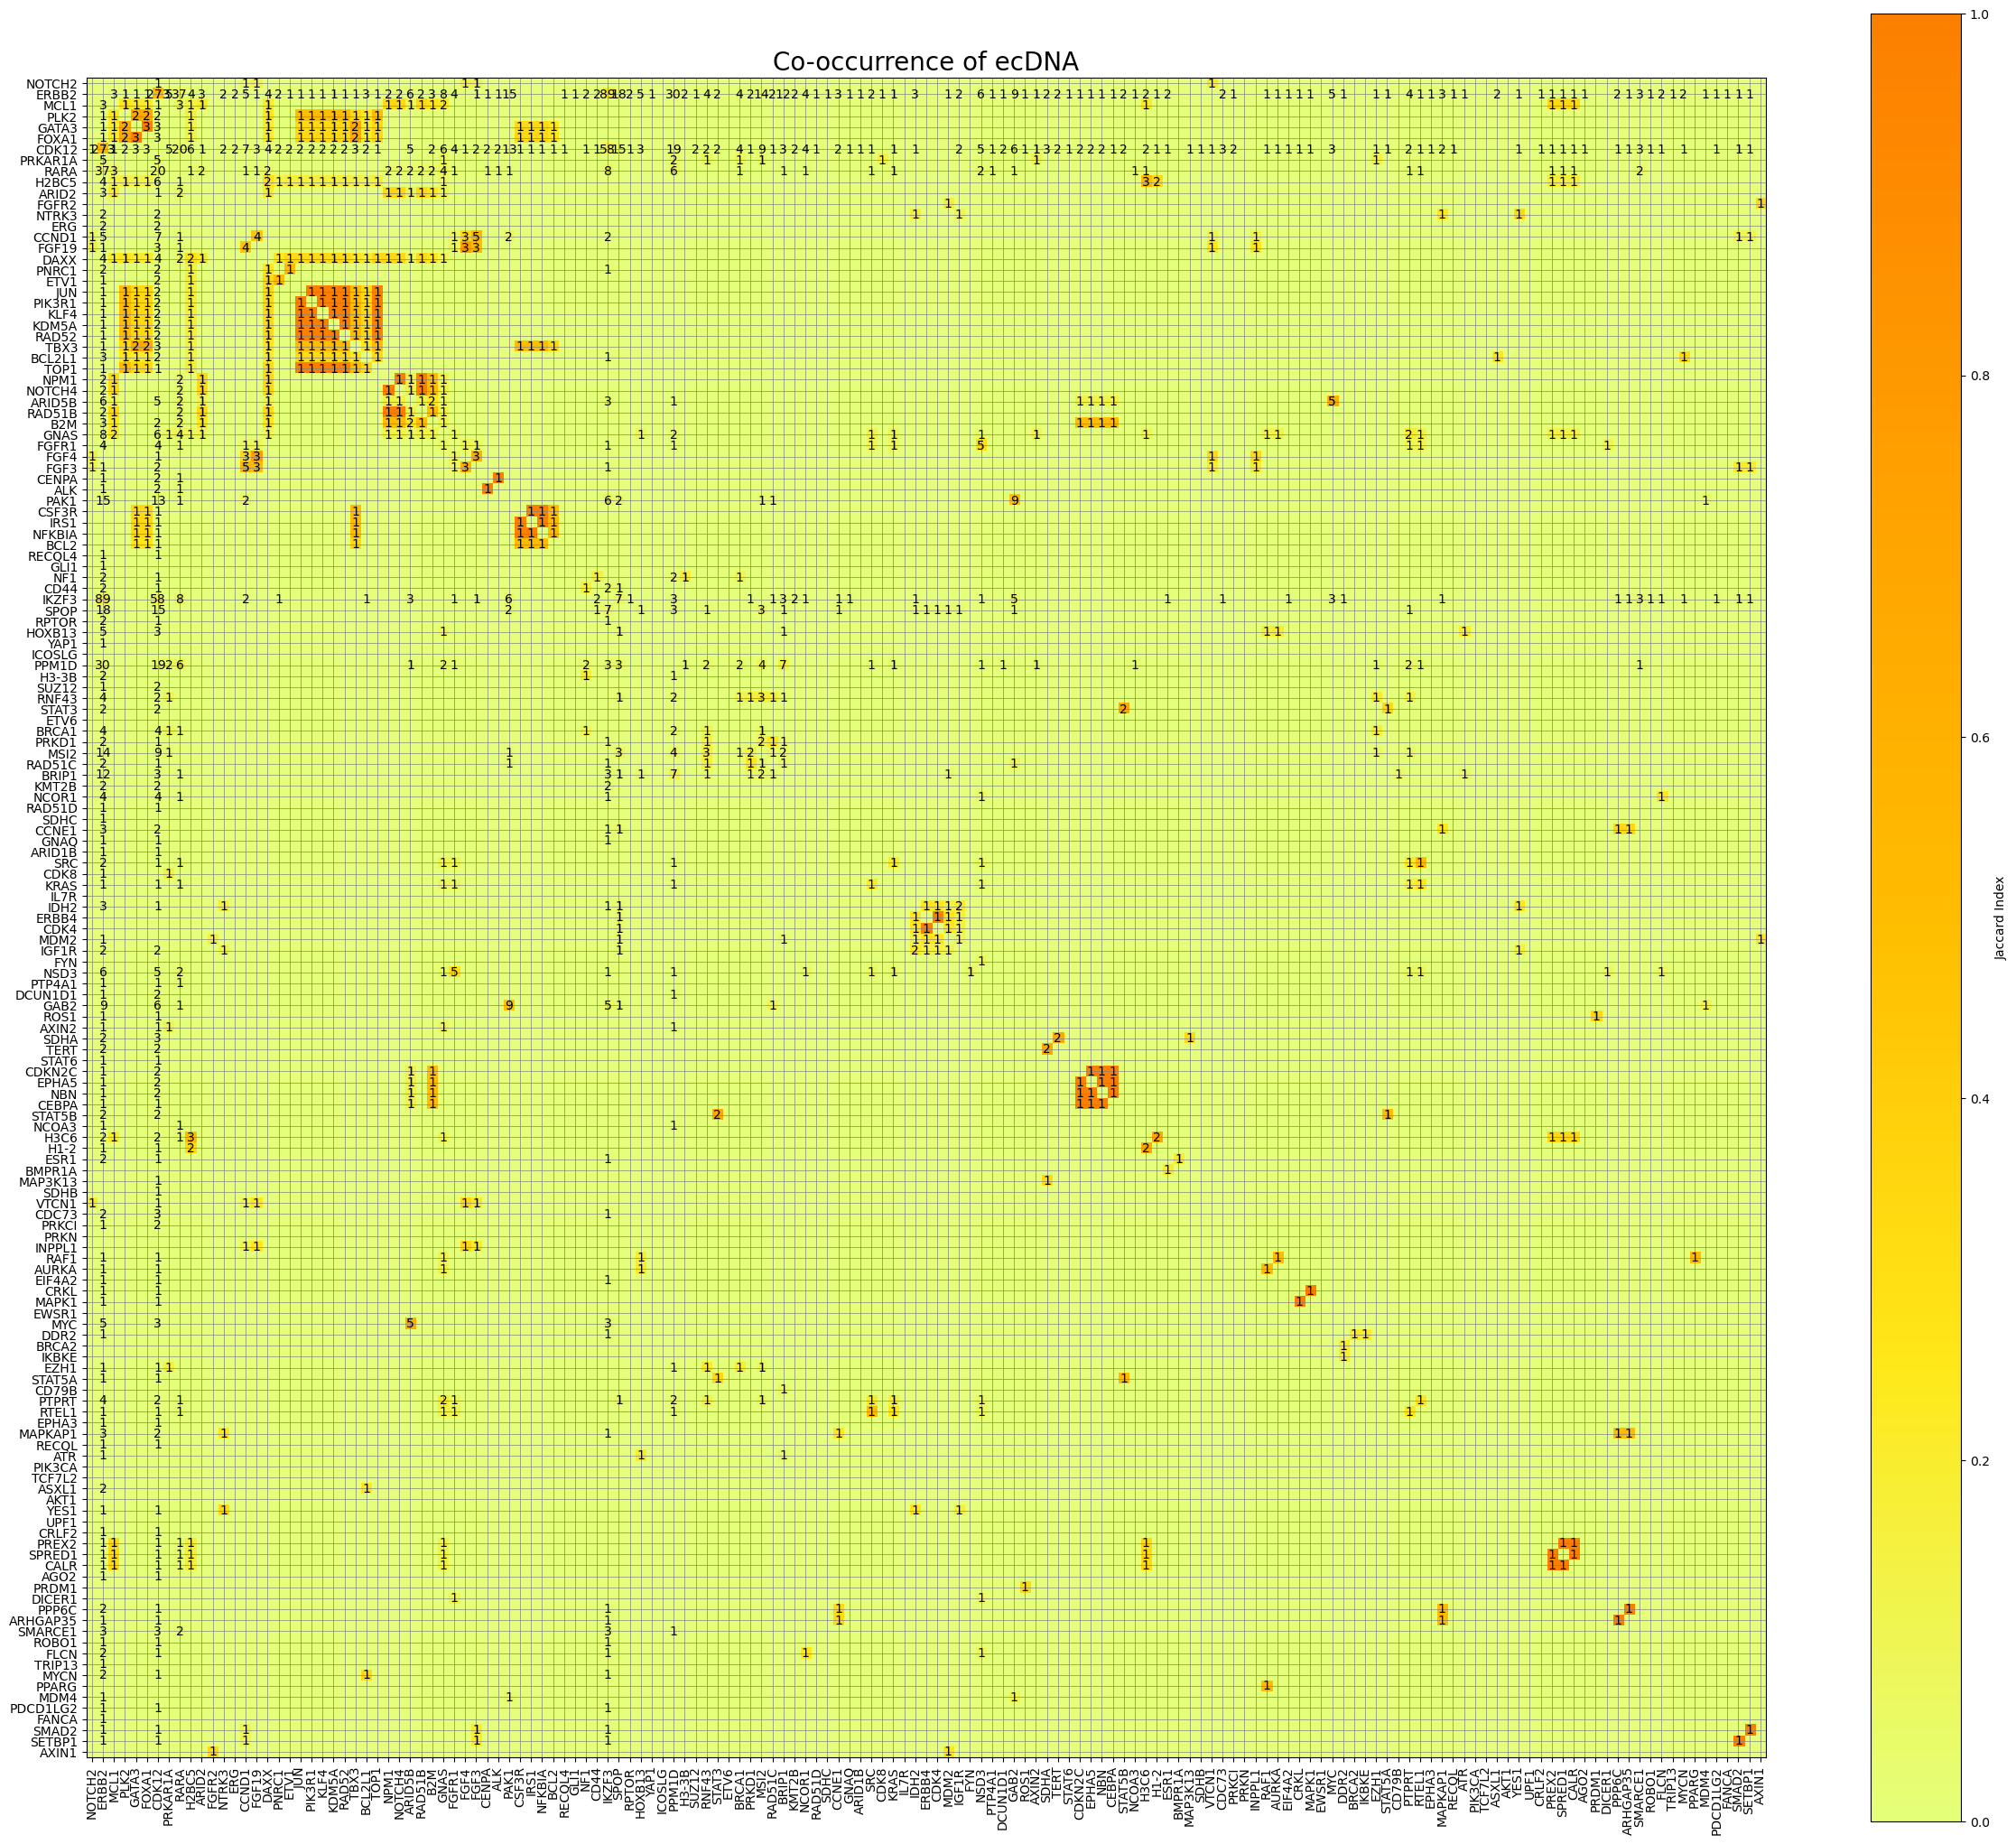

In [71]:
plt.figure(figsize=(30,26))
plt.grid(True, which='both', color='grey', linewidth=0.5)

plt.imshow(ecDNA_matrix_jaccard, cmap='Wistia', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Jaccard Index')
ticks = np.arange(len(reverse_ecDNA_indexes))
plt.xticks(ticks, [reverse_ecDNA_indexes[i] for i in range(len(reverse_ecDNA_indexes))], rotation=90)
plt.yticks(ticks, [reverse_ecDNA_indexes[i] for i in range(len(reverse_ecDNA_indexes))])


for i in range(len(reverse_ecDNA_indexes)):
    for j in range(len(reverse_ecDNA_indexes)):
        if ecDNA_matrix[i][j] != 0:
            plt.text(j, i, f"{ecDNA_matrix[i][j]}", ha='center', va='center', color='black')
plt.title("Co-occurrence of ecDNA", size = 20)
plt.show()

In [72]:


keep = [ecDNA_indexes[i] for i in list(gene_ecDNA_top15.keys())]
keep.sort()
dontkeep = [num for num in range(len(ecDNA_matrix_jaccard)) if num not in keep]
matrix_small = np.delete(ecDNA_matrix_jaccard, dontkeep, axis=0)
matrix_small = np.delete(matrix_small, dontkeep, axis=1)


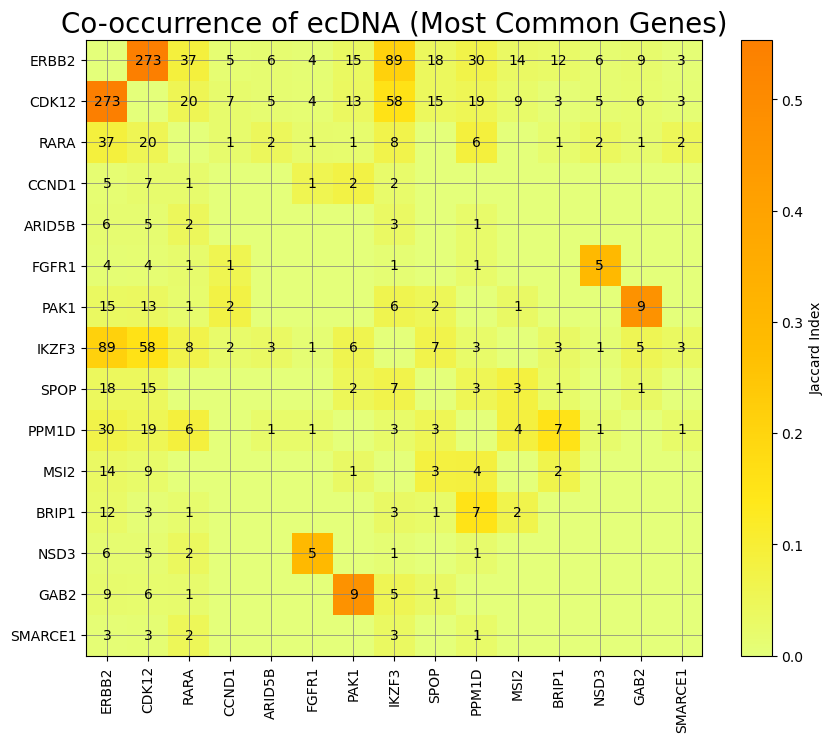

In [73]:
plt.figure(figsize=(10,8))
plt.grid(True, which='both', color='grey', linewidth=0.5)

plt.imshow(matrix_small, cmap='Wistia', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Jaccard Index')
ticks = np.arange(len(keep))
plt.xticks(ticks, [reverse_ecDNA_indexes[i] for i in keep], rotation=90)
plt.yticks(ticks, [reverse_ecDNA_indexes[i] for i in keep])


for i in range(len(keep)):
    for j in range(len(keep)):
        if ecDNA_matrix[keep[i]][keep[j]] != 0:
            plt.text(j, i, f"{ecDNA_matrix[keep[i]][keep[j]]}", ha='center', va='center', color='black')
plt.title("Co-occurrence of ecDNA (Most Common Genes)", size = 20)
plt.show()